# **LOADING THE DATASET**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
training_data_dir = '/content/drive/MyDrive/Fruits Classification/train'
validation_data_dir = '/content/drive/MyDrive/Fruits Classification/valid'
test_data_dir = '/content/drive/MyDrive/Fruits Classification/test'

# **IMPORTING THE LIBRARIES**
This code imports three libraries that are commonly used in data science and machine learning:

**import numpy as np:** NumPy is a fundamental library for numerical operations in Python. It provides support for arrays, matrices, and mathematical functions.

**import tensorflow as tf:** TensorFlow is a powerful library for building and training machine learning models, especially neural networks.

**import matplotlib.pyplot as plt:** Matplotlib is a plotting library for creating static, interactive, and animated visualizations in Python.
By importing these libraries, you gain access to their functionalities and can use them in your code.

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# **PREPROCESSING**
This code will load the training images from the `training_data_dir`, resize them to 100x100 pixels, shuffle them, and create batches of 32 images each. The images will be loaded in RGB format, and the labels will be inferred from the directory structure and encoded as integers.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for data augmentation
train_data_gen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_set = train_data_gen.flow_from_directory(
    training_data_dir,
    batch_size=32,
    target_size=(100, 100),
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)


Found 9700 images belonging to 5 classes.


**VALIDATION DATA PROCESSING**

same explanation as above

In [6]:
val_data_gen = ImageDataGenerator(rescale=1/255)

valid_data = val_data_gen.flow_from_directory(
    validation_data_dir,
    target_size=(100, 100),
    class_mode='sparse',
    color_mode="rgb",
    batch_size=32,
    shuffle= False,
)

Found 200 images belonging to 5 classes.


**TEST DATA PROCESSING**

same explanation as above

In [7]:
test_data_gen = ImageDataGenerator(rescale=1/255)

test_set = test_data_gen.flow_from_directory(
    test_data_dir,
    target_size=(100, 100),
    class_mode='sparse',
    color_mode="rgb",
    batch_size=32,
    shuffle= False,
)

Found 100 images belonging to 5 classes.


# LITTLE DATA EXPLORATION
This code snippet defines and uses a function to display a batch of images from a TensorFlow dataset of images, along with their corresponding labels.


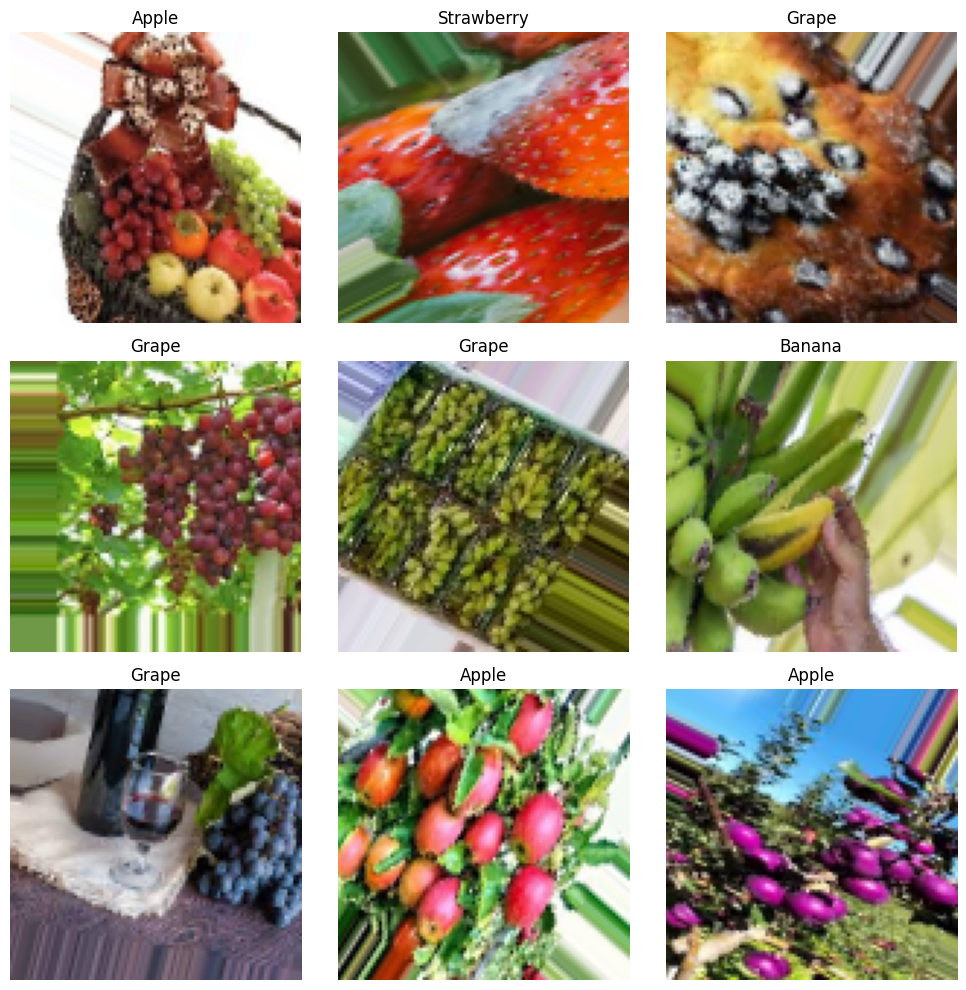

In [ ]:
import matplotlib.pyplot as plt

# Function to plot images
def plot_images(generator):
    images, labels = next(generator)
    class_indices = {v: k for k, v in generator.class_indices.items()}

    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display the first 9 images
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(class_indices[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot images from the training generator
plot_images(train_set)



# **TRAINING THE MODEL**

To know if our data labels are in integer form or one hot encoded. This helps us to know if we are using between sparse_categorical_crossentropy and categorical_crossentropy.
**sparse_categorical_crossentropy:**

1. Use this when your target labels are integers.

2. Each label is an integer representing the correct class.

3. Example: If you have three classes, the labels could be [0, 1, 2].

**categorical_crossentropy:**

1. Use this when your target labels are one-hot encoded.

2. Each label is a binary vector with a 1 in the position of the correct class and 0s elsewhere.

3. Example: If you have three classes, the labels could be [[1, 0, 0], [0, 1, 0], [0, 0, 1]].

In summary:
Use sparse_categorical_crossentropy for integer labels.
Use categorical_crossentropy for one-hot encoded labels.

In [ ]:
import numpy as np

def check_labels(generator):
    images, labels = next(generator)

    if len(labels.shape) == 1:
        print("Labels are integers (sparse).")
    elif len(labels.shape) == 2:
        if np.array_equal(labels, labels.astype(bool)):
            print("Labels are one-hot encoded.")
        else:
            print("Labels are in an unexpected format.")
    else:
        print("Labels are in an unexpected format.")

# Check labels from the training generator
check_labels(train_set)


Labels are integers (sparse).


BUILDING THE MODEL

# **CUSTOM CNN MODEL**


In [ ]:
# BUILDING SEQUENTIAL MODEL
model = tf.keras.models.Sequential()

# BUILDING CONVOLUTIONAL LAYERS
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=[100, 100, 3], padding = 'same'))

#BUILDING POOLING LAYERSs
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

#REPEAT THE PROCESS TO EXTRACT MORE IMPORTANT FEATURES
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))


model.add(tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

model.add(tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# FLATTENING THE LAYER
model.add(tf.keras.layers.Flatten())

#BUILDING FULLY CONNECTED LAYERS
model.add(tf.keras.layers.Dense(units= 256, activation='relu'))

model.add(tf.keras.layers.Dropout(0.3)) # to solve the problem of overfitting
#BUILDING OUTPUT LAYER
model.add(tf.keras.layers.Dense(units= 5, activation='softmax'))


COMPILING AND TRAINING

### Compiling the Model
```python
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
```
- **compile**: This method configures the model for training.
- **optimizer='adam'**: The optimizer controls how the model updates its weights during training. 'adam' (Adaptive Moment Estimation) is a popular choice because it adapts the learning rate during training, making it efficient and effective.
- **loss='sparse_categorical_crossentropy'**: The loss function measures how well the model's predictions match the true labels. 'sparse_categorical_crossentropy' is used when the target labels are integers (not one-hot encoded). It helps the model improve by minimizing this loss during training.
- **metrics=['accuracy']**: Metrics are used to evaluate the model's performance. 'accuracy' measures the percentage of correct predictions.

### Defining Early Stopping Callback
```python
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
```
- **EarlyStopping**: This is a callback that stops training when the model's performance on the validation set stops improving.
- **monitor='val_loss'**: This specifies which metric to monitor for early stopping. 'val_loss' is the loss on the validation set.
- **patience=5**: This means that if the 'val_loss' doesn't improve for 5 consecutive epochs, training will be stopped. It gives the model a chance to improve even if it doesn't show immediate progress.
- **restore_best_weights=True**: After stopping, this restores the model's weights to the state where 'val_loss' was the best. This ensures that the model doesn't just have good performance on the last epoch, but the best possible performance during training.

### Training the Model with Early Stopping
```python
history = model.fit(x=train_set,
                    validation_data=valid_set,
                    epochs=30,
                    callbacks=[early_stopping])
```
- **fit**: This method trains the model.
- **x=train_set**: The training data. It's usually a collection of images and their corresponding labels.
- **validation_data=valid_set**: The validation data. It's used to evaluate the model's performance after each epoch but is not used for training.
- **epochs=30**: The number of times to iterate over the entire training dataset. An epoch is one complete pass through the training data. Number of epochs is subject to change.
- **callbacks=[early_stopping]**: A list of callback functions to apply during training. Here, it's the early stopping callback we defined earlier. This will monitor the validation loss and stop training early if it stops improving.

### Summary
- The model is compiled with the Adam optimizer, sparse categorical cross-entropy loss, and accuracy as a metric.
- Early stopping is set up to monitor validation loss and stop training if it doesn't improve for 5 epochs, restoring the best weights.
- The model is trained on the training data with validation data provided to check performance after each epoch. Training can run for up to 30 epochs, but early stopping might end it sooner if the validation loss stops improving.

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define Early Stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define Model Checkpoint callback to save the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model1.keras',
                                                monitor='val_loss',
                                                save_best_only=True,
                                                mode='min')

# Train the model with Early Stopping and Model Checkpoint
history = model.fit(x=train_set,
                    validation_data=valid_data,
                    epochs=20,
                    callbacks=[early_stopping, checkpoint])

Epoch 1/20
304/304 [==============================] - 2341s 8s/step - loss: 1.3261 - accuracy: 0.4139 - val_loss: 1.1382 - val_accuracy: 0.5300
Epoch 2/20
304/304 [==============================] - 63s 206ms/step - loss: 1.1162 - accuracy: 0.5295 - val_loss: 1.0386 - val_accuracy: 0.5700
Epoch 3/20
304/304 [==============================] - 63s 206ms/step - loss: 1.0550 - accuracy: 0.5630 - val_loss: 0.9776 - val_accuracy: 0.6350
Epoch 4/20
304/304 [==============================] - 62s 204ms/step - loss: 0.9994 - accuracy: 0.5932 - val_loss: 0.9650 - val_accuracy: 0.5800
Epoch 5/20
304/304 [==============================] - 63s 205ms/step - loss: 0.9718 - accuracy: 0.6088 - val_loss: 0.8985 - val_accuracy: 0.6400
Epoch 6/20
304/304 [==============================] - 63s 206ms/step - loss: 0.9457 - accuracy: 0.6235 - val_loss: 0.8730 - val_accuracy: 0.6200
Epoch 7/20
304/304 [==============================] - 62s 204ms/step - loss: 0.9219 - accuracy: 0.6349 - val_loss: 0.9062 - val_acc

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 128)       0

LINE GRAPH

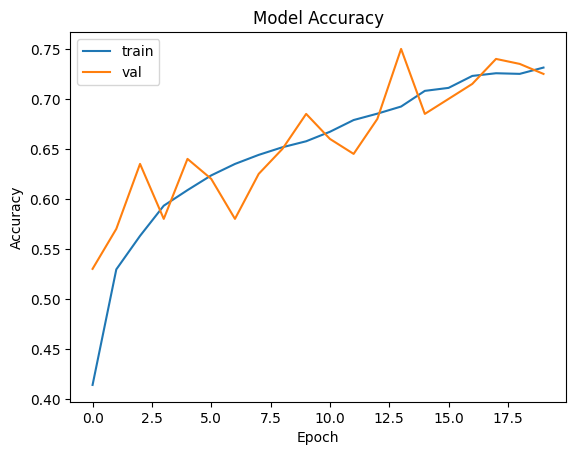

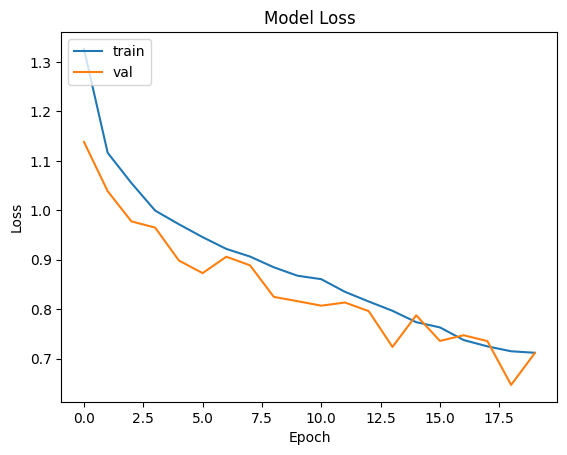

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


MODEL EVALUATION

This code evaluates the performance of a trained neural network model using common classification metrics: accuracy, precision, recall, and F1 score. It uses the `sklearn` library to calculate these metrics.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the best model1
best_model = tf.keras.models.load_model('best_model1.keras')

# Make predictions on the test set
test_predictions = []
test_labels = []

for images, labels in test_set:
    preds = best_model.predict(images)
    test_predictions.extend(tf.argmax(preds, axis=1).numpy())
    test_labels.extend(labels)
    # Break after collecting predictions for 10 batches
    if len(test_predictions) >= 10 * test_set.batch_size:
        break

test_predictions = tf.constant(test_predictions[:10 * test_set.batch_size])
test_labels = tf.constant(test_labels[:10 * test_set.batch_size])

# Calculate metrics
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average='weighted')
recall = recall_score(test_labels, test_predictions, average='weighted')
f1 = f1_score(test_labels, test_predictions, average='weighted')

# Print the metrics
print(f'Best Model Accuracy on Small Test Set: {accuracy}')
print(f'Best Model Precision on Small Test Set: {precision}')
print(f'Best Model Recall on Small Test Set: {recall}')
print(f'Best Model F1 Score on Small Test Set: {f1}')

1/1 [==============================] - 0s 52ms/step
Best Model Accuracy on Small Test Set: 0.740625
Best Model Precision on Small Test Set: 0.7426037644787645
Best Model Recall on Small Test Set: 0.740625
Best Model F1 Score on Small Test Set: 0.7388249381103884


# ResNet50

Transfer learning

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load the ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Create a new model with ResNet50 as the base
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    #Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Add a callback for early stopping to prevent overfitting
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_set,
    epochs=20,
    validation_data=valid_data,
    callbacks=[early_stopping_callback]
)


Epoch 1/20
  2/304 [..............................] - ETA: 2:36 - loss: 2.0174 - accuracy: 0.2656   

KeyboardInterrupt: 

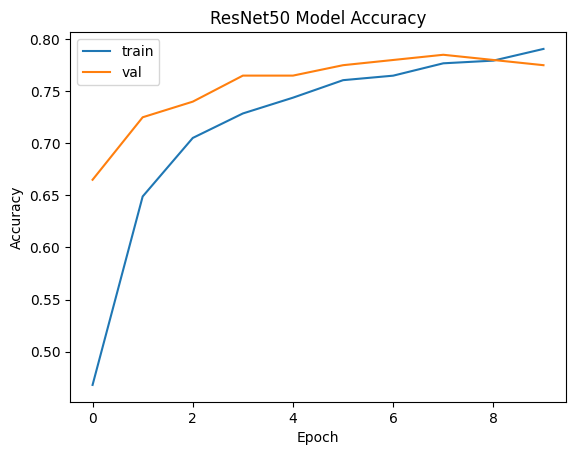

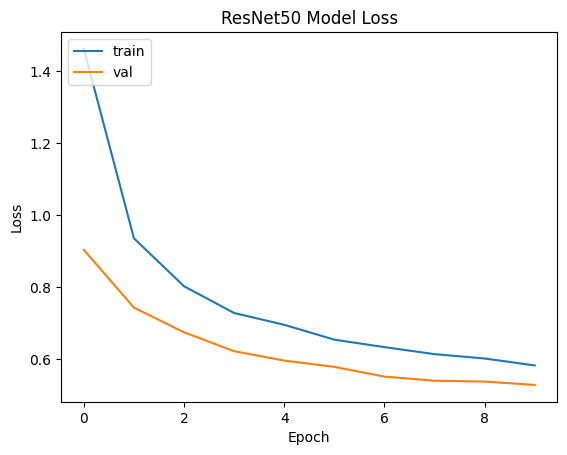

In [ ]:

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Make predictions on the test set
test_predictions = []
test_labels = []

for images, labels in test_set:
    preds = model.predict(images)
    test_predictions.extend(tf.argmax(preds, axis=1).numpy())
    test_labels.extend(labels)
    # Break after collecting predictions for 10 batches
    if len(test_predictions) >= 10 * test_set.batch_size:
        break

test_predictions = tf.constant(test_predictions[:10 * test_set.batch_size])
test_labels = tf.constant(test_labels[:10 * test_set.batch_size])

# Calculate metrics
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average='weighted')
recall = recall_score(test_labels, test_predictions, average='weighted')
f1 = f1_score(test_labels, test_predictions, average='weighted')

# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


1/1 [==============================] - 1s 970ms/step
Accuracy: 0.79
Precision: 0.7864919652071355
Recall: 0.79
F1 Score: 0.7857049783879052
